# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- nltk 3.7
- tensorflow 2.9.1


### Vamos a cargar un datasets de noticias (texto). Las noticias están anotadas en 20 clases temáticas. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_20newsgroups

X_train_text, Y_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test_text, Y_test  = fetch_20newsgroups(subset="test", remove=('headers', 'footers', 'quotes'), return_X_y=True)

2023-10-14 13:35:06.799849: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Preprocesaremos el texto: 1: Eliminamos palabras muy comunes (stopwords), 2: Usamos un lematizador para reducir las palabras a su raíz semánticas (autos, automóviles, carros- > auto), 3: Pasamos todo a minúsculas. 

In [2]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

classes = np.unique(Y_train)

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
# It's also possible to try with a stemmer or to mix a stemmer and a lemmatizer
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    text = ' '.join(words)
    return text

### Preprocesamos las particiones de training y testing

In [3]:
train_docs = []
test_docs = []

for raw_text in X_train_text:
    text = tokenize(raw_text)
    train_docs.append(text)
    
for raw_text in X_test_text:
    text = tokenize(raw_text)
    test_docs.append(text)
    

### Vamos a hacer padding. Esto es, proyectar secuencias de largo variable (texto) a largo fijo. Esto debido a que debemos dimensionar los vectores de entrada de la red neuronal. En este ejemplo, todo se proyecto a secuencias de largo fijo 50 tokens. Si el ejemplo es mas corto, usamos un token por defecto (pad). En este caso, el padding se hace al final de la secuencia (post padding).

In [5]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_tokens = 50 ## Hyperparameter, input length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs+test_docs)

## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(train_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(test_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)


X_train_vect.shape, X_test_vect.shape

((11314, 50), (7532, 50))

### Definimos la arquitectura de la red neuronal. La salida es una softmax con tantas neuronas como clases tiene el dataset.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input

inputs = Input(shape=(max_tokens, ))
embeddings_layer = Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=50, input_length=max_tokens, trainable=True)
dense1 = Dense(128, activation="relu")
dense2 = Dense(64, activation="relu")
dense3 = Dense(len(classes), activation="softmax")

x = embeddings_layer(inputs)
x = tf.reduce_sum(x, axis=1) # puede usar mean u otras función de agregación de vectores. 
x = dense1(x)
x = dense2(x)
outputs = dense3(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            4753900   
                                                                 
 tf.math.reduce_sum (TFOpLam  (None, 50)               0         
 bda)                                                            
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                             

2023-10-14 13:39:44.102124: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-14 13:39:44.102157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marcelo-Precision-5820-Tower): /proc/driver/nvidia/version does not exist
2023-10-14 13:39:44.102549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Vamos a compilar el model. Aquí se declara el optimizador y la función de pérdida que vimos en clases. La métrica a reportar durante el entrenamiento es accuracy en este caso.

In [7]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Vamos a usar una estrategia de entrenamiento que se llama early stopping. Si pasan 3 iteraciones sin mejores en la función de pérdida, nos detenemos.

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

### Tenemos casi todo listo para entrenar la red. Nos falta definir el batch_size y cuantos epochs le vamos a dar al entrenamiento. Fíjense que el accuracy debe ir bajando gradualmente (es decir, el modelo aprende). 

In [9]:
model.fit(X_train_vect, Y_train, batch_size=32, epochs=20, callbacks=[callback])

Epoch 1/20
354/354 [==============================] - 7s 20ms/step - loss: 1.8625 - accuracy: 0.4482
Epoch 2/20
354/354 [==============================] - 7s 20ms/step - loss: 0.5820 - accuracy: 0.8346
Epoch 3/20
354/354 [==============================] - 7s 20ms/step - loss: 0.2625 - accuracy: 0.9308
Epoch 4/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1714 - accuracy: 0.9570
Epoch 5/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1483 - accuracy: 0.9630
Epoch 6/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1341 - accuracy: 0.9661
Epoch 7/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1250 - accuracy: 0.9683
Epoch 8/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1138 - accuracy: 0.9696
Epoch 9/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1082 - accuracy: 0.9696
Epoch 10/20
354/354 [==============================] - 7s 20ms/step - loss: 0.1029 - accura

### Fíjense que hizo early stopping. Ahora vamos a ver el desempeño.

In [10]:
labels = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Y vemos el desempeño por clase

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=labels))

236/236 [==============================] - 1s 2ms/step
Test Accuracy : 0.5645246946362188

Classification Report : 
                          precision    recall  f1-score   support

             alt.atheism       0.44      0.34      0.38       319
           comp.graphics       0.47      0.60      0.53       389
 comp.os.ms-windows.misc       0.57      0.55      0.56       394
comp.sys.ibm.pc.hardware       0.51      0.57      0.54       392
   comp.sys.mac.hardware       0.35      0.65      0.45       385
          comp.windows.x       0.72      0.57      0.64       395
            misc.forsale       0.75      0.65      0.70       390
               rec.autos       0.61      0.54      0.57       396
         rec.motorcycles       0.56      0.66      0.61       398
      rec.sport.baseball       0.69      0.69      0.69       397
        rec.sport.hockey       0.83      0.75      0.78       399
               sci.crypt       0.70      0.60      0.65       396
         sci.electronics 

In [12]:
import itertools, matplotlib.pyplot as plt, numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


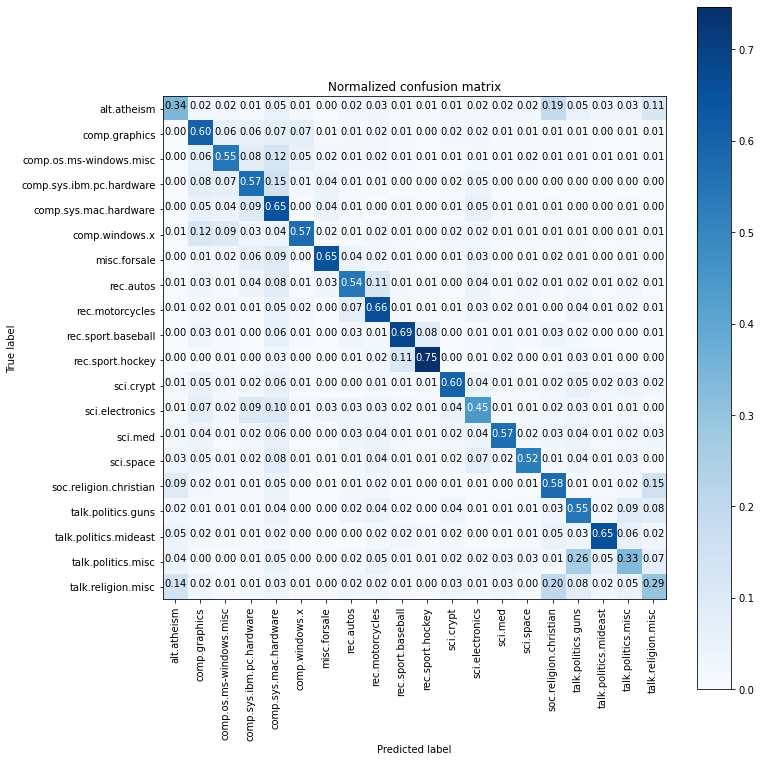

In [13]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(Y_test, Y_preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()